# Report over Segmentation Results #

In [1]:
!pip install -e ../..

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///netscratch2/alontke/master_thesis/code/ssl-ddpm-rs
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/AlexanderLontke/lit-diffusion.git to /tmp/pip-install-m47d88gx/lit-diffusion_4a6f6bfa22514d8fab413cee1497a4ac
  Running command git clone -q https://github.com/AlexanderLontke/lit-diffusion.git /tmp/pip-install-m47d88gx/lit-diffusion_4a6f6bfa22514d8fab413cee1497a4ac
  Resolved https://github.com/AlexanderLontke/lit-diffusion.git to commit 272566425162cdda6fa70518a079c15d08a7d644
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/Al

In [6]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Remote Sensing DDPM
from remote_sensing_ddpm.train_downstream_tasks import create_wandb_run_name, LABEL_FRACTION_PATHS

# Lit-Diffusion
from lit_diffusion.diffusion_base.constants import LOGGING_TRAIN_PREFIX, LOGGING_VAL_PREFIX
from lit_diffusion.constants import (
    PL_WANDB_LOGGER_CONFIG_KEY,
)

# FWTP
from from_wandb_to_paper.data.wandb_data import get_wandb_run_histories
from from_wandb_to_paper.figures.aggregated_runs_with_error import aggregate_run_histories

## Config ##

In [7]:
FEATURE_EXTRACTOR_FILES = Path("../../config/model_configs/downstream_tasks/feature_extractors")
EWC_SEGMENTATION_CONFIG_PATH = Path("../../config/model_configs/downstream_tasks/tier_1/ewc-segmentation.yaml")

WAND_PROJECT_ID = "ssl-diffusion/rs-ddpm-ms-segmentation-egypt"

## Get Data ##

In [8]:
FEATURE_EXTRACTOR_NAMES = list(FEATURE_EXTRACTOR_FILES.glob("*.yaml"))
MODALITY_NAMES = [p.name.split(".")[0] for p in FEATURE_EXTRACTOR_NAMES]
EXPERIMENT_NAMES = [
    create_wandb_run_name(backbone_name=backbone_path.name, downstream_head_name=EWC_SEGMENTATION_CONFIG_PATH.name)
    for backbone_path in FEATURE_EXTRACTOR_NAMES
]
LABEL_FRACTION_EXPERIMENT_NAMES = [
    name + f"-lf-{fraction}"
    for name in EXPERIMENT_NAMES
    for fraction in LABEL_FRACTION_PATHS.keys()
]

In [59]:
EXPERIMENT_NAMES = ["s2_rgb_nir-ewc-segmentation", "s2_s1-ewc-segmentation"]
MODALITY_NAMES = ["s2_rgb_nir", "s2_s1"]

In [11]:
# Create run filters

# Filter for std experiment runs
# RUN_FILTER = {"name": {"$in": ["2p2n4tv2", "aa2yxpin", "ues188te", "pws0vl7w", "exffot4s"]}}

# Filter for all training runs
RUN_FILTER = {"$and": [{"display_name": {"$in": EXPERIMENT_NAMES}}, {"state": {"$eq": "finished"}}]}

# Filter for all label fraction runs
# TODO

In [12]:
run_histories = get_wandb_run_histories(
    project_id=WAND_PROJECT_ID, run_filter=RUN_FILTER
)

Loading history: 31640it [00:20, 1531.36it/s]
Loading history: 155340it [01:59, 1295.09it/s]
Loading history: 155340it [02:11, 1180.38it/s]
Loading history: 155340it [02:17, 1129.91it/s]
Loading history: 155340it [01:59, 1299.73it/s]
Loading history: 155340it [02:02, 1264.08it/s]
Loading history: 155340it [01:59, 1295.93it/s]
Loading history: 155340it [02:08, 1212.79it/s]
Loading history: 155340it [01:56, 1337.27it/s]


In [14]:
import pickle

with open("./tmp_segmentation_run_histories.pkl", "wb") as dump_file:
    pickle.dump(run_histories, dump_file)

In [21]:
cleaned_run_histories = {k:v for k, v in run_histories.items() if len(v["history"]) == 155340}

## Report Metrics ##

In [61]:
run_histories_ordered_by_modality = {
    modality_name: {
        run_id: run_history
        for run_id, run_history in cleaned_run_histories.items()
        if run_history["name"].split("-")[0] == modality_name
    }
    for modality_name in MODALITY_NAMES
}

In [64]:
# TODO: Graph showing the epoch validation trajectory of the mIoU/Accuracy for each modality
metrics_of_interest = ["train/mIoU", "val/mIoU"]
modality_aggregates = {
    modality_name: aggregate_run_histories(metrics_of_interest=metrics_of_interest, run_histories=modal_run_histories)
    for modality_name, modal_run_histories in run_histories_ordered_by_modality.items()
}

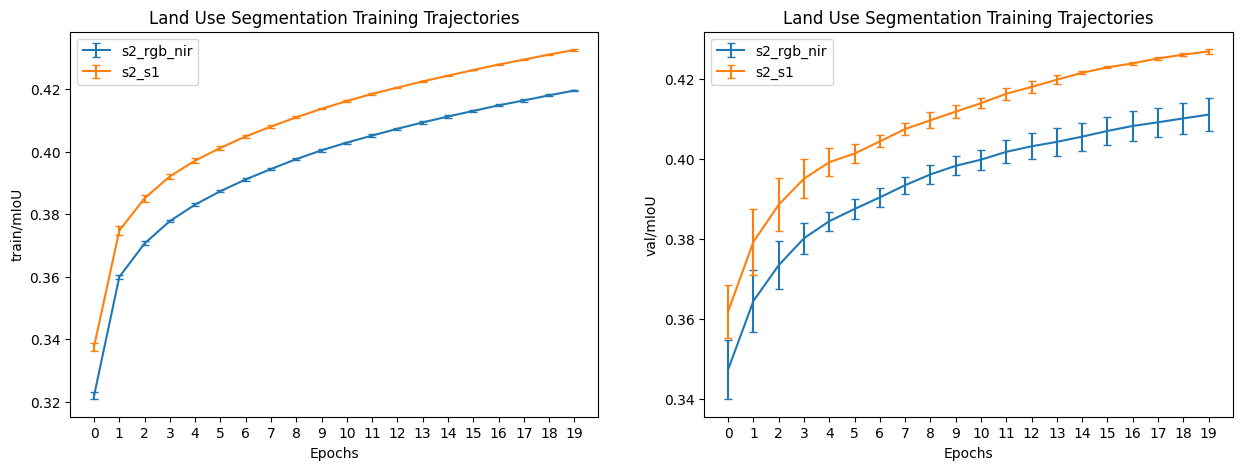

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=len(metrics_of_interest), figsize=(15, 5))

# TODO add legend and multiple lines one for each modality
for modality, aggregate in modality_aggregates.items():
    i = 0
    for metric, aggregates_dict in aggregate.items():
        yerr = []
        x = []
        y = []
        for k, v in aggregates_dict[MEAN_KEY].items():
            x += [int(k)]
            y += [v]
            yerr += [aggregates_dict[STD_KEY][k]]
        ax = axs[i]
        ax.errorbar(x=x, y=y, yerr=yerr, capsize=3, label=modality)
        ax.set_xticks(x)
        ax.set_title(f"Land Use Segmentation Training Trajectories")
        ax.set_xlabel("Epochs")
        ax.set_ylabel(f"{metric}")
        ax.legend()
        i+=1

In [79]:
index = pd.MultiIndex.from_product([MODALITY_NAMES, ["mean", "std"]])

In [98]:
# TODO: Table showing metrics for the mIoU/accuracy of each modality with standard deviation
df = pd.DataFrame({(outerKey, innerKey): {k: v[19.0] for k, v in values.items()} for outerKey, innerDict in modality_aggregates.items() for innerKey, values in innerDict.items()})
print(df.style.to_latex())

\begin{tabular}{lrrrr}
 & \multicolumn{2}{r}{s2_rgb_nir} & \multicolumn{2}{r}{s2_s1} \\
 & train/mIoU & val/mIoU & train/mIoU & val/mIoU \\
mean & 0.419611 & 0.411052 & 0.432614 & 0.426854 \\
std & 0.000295 & 0.004108 & 0.000223 & 0.000543 \\
\end{tabular}



In [31]:
# TODO: Table showing classwise metrics for the mIoU/accuracy of each modality with standard deviation

## Report Label Fraction Experiments ##

In [ ]:
# TODO Graph showing the mIoU/accuracy per label fraction used each modality 